In [1]:
import torch
import torch.nn as nn
from transformers import LlamaForCausalLM, AutoTokenizer
from mars_mmkg import *
from transformers import CLIPProcessor, CLIPModel
from torch_geometric.nn import NNConv
from PIL import Image

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Setting

0-1. CLIP

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

0-2. Llama2

In [4]:
llm_model_name="winglian/Llama-2-3b-hf" # light llama 
llm_model = LlamaForCausalLM.from_pretrained(llm_model_name)
llm_model = llm_model.to(device).eval()
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)

0-3. MMKG

In [5]:
entity2text_path = "MarKG/entity2text.txt"
relation2text_path = "MarKG/relation2text.txt"
kg_path = "MarKG/wiki_tuple_ids.txt"
mars_img_embed_path = "mars_image_embeddings.h5"

In [6]:
entity_dict = get_entity_dict(entity2text_path)
relation_dict = get_relation_dict(relation2text_path)
mars_kg = MARS_KG(kg_path, entity_dict, relation_dict, clip_model, clip_processor, device)
mars_img_embed = get_all_img_embed(mars_img_embed_path)

In [7]:
KG_entities = mars_kg.KG_entities
KG_relations = mars_kg.KG_relations
print('Num of Entities:', len(KG_entities))
print('Num of relations:', len(KG_relations))

Num of Entities: 9903
Num of relations: 191


0-4. Retrieve subMMKG for Multimodal Analogical Reasoning 

In [8]:
def generate_prompt(entity1, entity2, relation):
    prompt = (
        f'"{entity1}" and "{entity2}" are related by the relation "{relation}". '
        f'Based on this, what is the text that has the same relation "{relation}" with the given image?'
    )
    return prompt

Question:  "croissant" and "pastry" are related by the relation "subclass of". Based on this, what is the text that has the same relation "subclass of" with the given image?


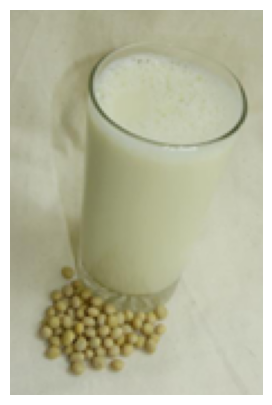

In [9]:
sample_entity1, sample_entity2, sample_relation = 'croissant', 'pastry', 'subclass of'
question_prompt = generate_prompt(sample_entity1, sample_entity2, sample_relation)
print('Question: ',question_prompt)

# visualization
sample_img_path = 'sample_img_soymilk.png'
sample_img_PIL = Image.open(sample_img_path)
plt.figure(figsize=(5, 5))
plt.imshow(sample_img_PIL)
plt.axis('off')  
plt.show()

[SubKG-Mode.1] Early fusion: emb(triple text) + emb(image) -> Graph 

/home/sha/Pyler/MKG_Analogy/MarT/dataset/mars_mmkg.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


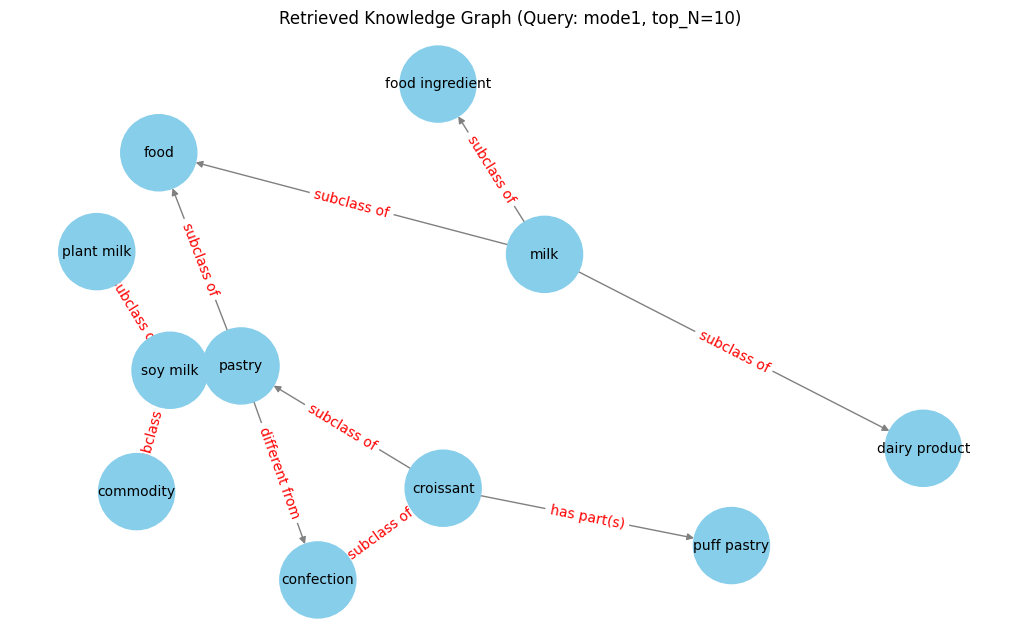

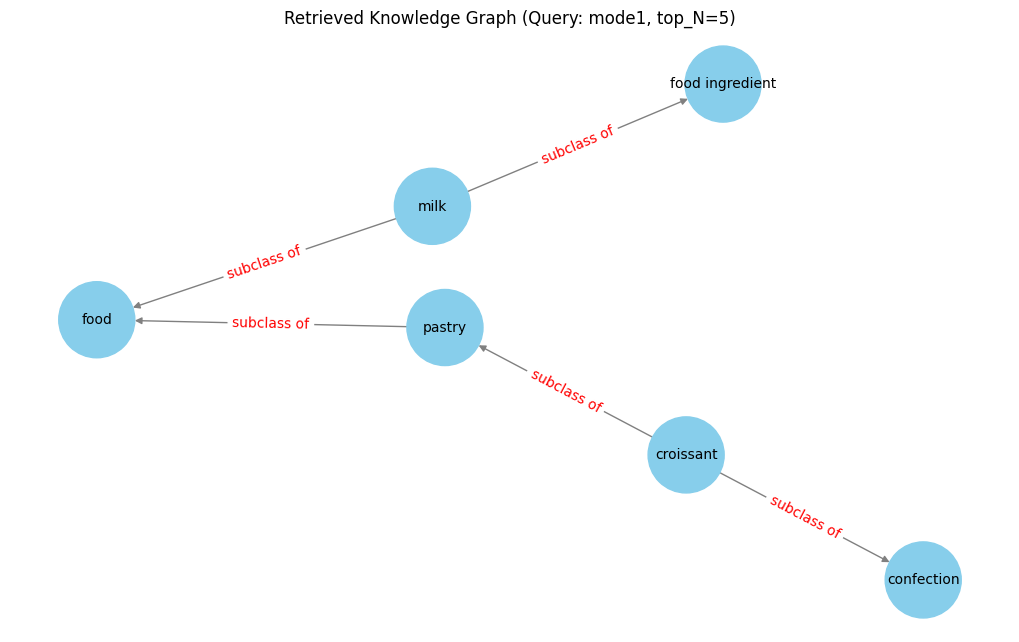

In [10]:
triple_text = f'{sample_entity1}-{sample_relation}-{sample_entity2}'
query = [triple_text, sample_img_PIL]

# top_N = 10
sub_KG = mars_kg.get_sub_KG(query, query_mode=0, top_N=10)
draw_knowledge_graph(sub_KG, 'mode1, top_N=10')

# top_N = 5
sub_KG = mars_kg.get_sub_KG(query, query_mode=0, top_N=5)
draw_knowledge_graph(sub_KG, 'mode1, top_N=5')

[SubKG-Mode.2] Late fusion: emb(triple text) -> Graph1, emb(image) -> Graph2, Graph1+Graph2 -> Graph

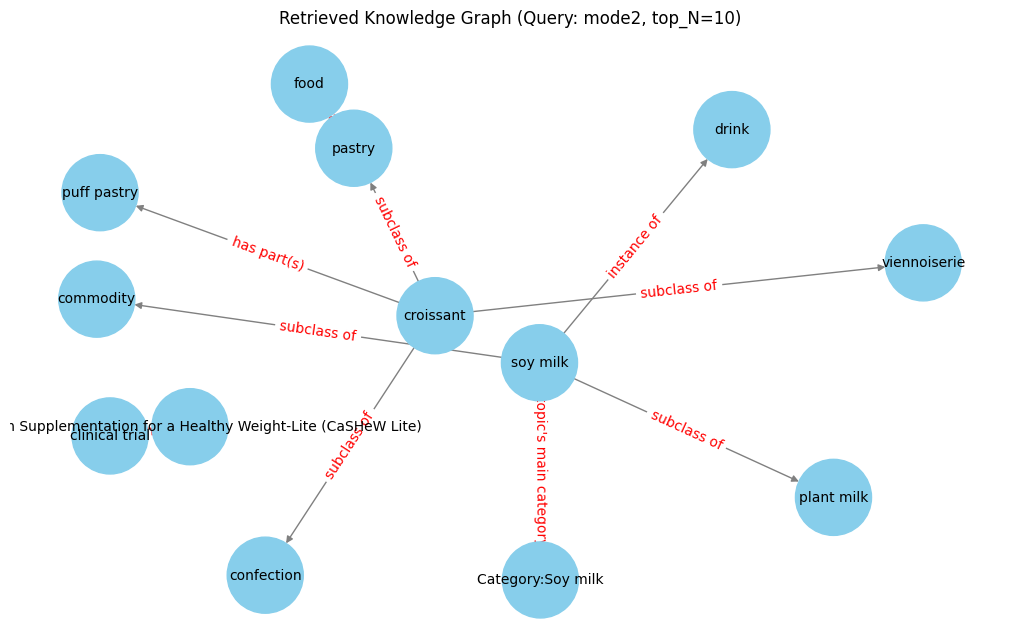

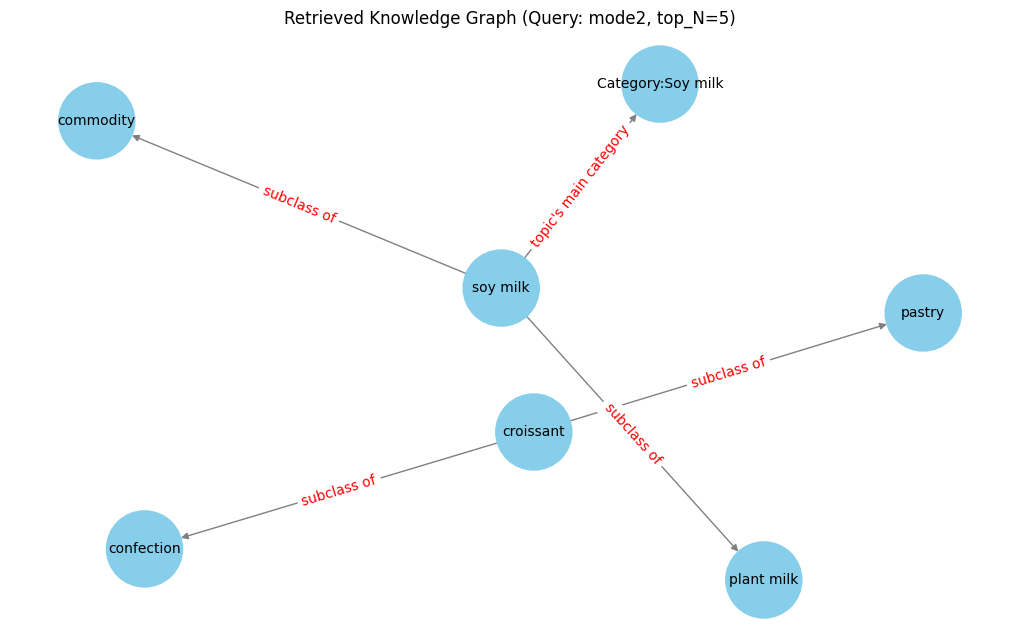

In [11]:
query1 = f'{sample_entity1}-{sample_relation}-{sample_entity2}'
query2 = sample_img_PIL

# top_N = 10
sub_KG1 = mars_kg.get_sub_KG(query1, query_mode=1, top_N=5)
sub_KG2 = mars_kg.get_sub_KG(query2, query_mode=1, top_N=5)
sub_KG = sub_KG1 + sub_KG2
draw_knowledge_graph(sub_KG, 'mode2, top_N=10')

# top_N = 5
sub_KG1 = mars_kg.get_sub_KG(query1, query_mode=1, top_N=2)
sub_KG2 = mars_kg.get_sub_KG(query2, query_mode=1, top_N=3)
sub_KG = sub_KG1 + sub_KG2
draw_knowledge_graph(sub_KG, 'mode2, top_N=5')

In [12]:
sub_MMKG = make_subMMKG(sub_KG, entity_dict)
for i, item in enumerate(sub_MMKG):
    print(i, item)

0 ('croissant', 'subclass of', 'pastry')
1 ('croissant', 'subclass of', 'confection')
2 ('soy milk', "topic's main category", 'Category:Soy milk')
3 ('soy milk', 'subclass of', 'commodity')
4 ('soy milk', 'subclass of', 'plant milk')
5 ('IMG:Q3303391', 'imagee of', 'Category:Soy milk')
6 ('IMG:Q317088', 'imagee of', 'commodity')
7 ('IMG:Q5159627', 'imagee of', 'confection')
8 ('IMG:Q207832', 'imagee of', 'croissant')
9 ('IMG:Q477248', 'imagee of', 'pastry')
10 ('IMG:Q2640574', 'imagee of', 'plant milk')
11 ('IMG:Q192199', 'imagee of', 'soy milk')


---

#### 1. Language Encoder

In [13]:
def get_language_embedding(text, tokenizer, llama_model, device):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    with torch.no_grad():
        language_embed = llama_model.model.embed_tokens(input_ids)  # (B, T, D)  
    return language_embed

In [14]:
input_text = question_prompt
language_embed = get_language_embedding(input_text, llm_tokenizer, llm_model, device)

print(input_text)
print('Language Embedding shape:', language_embed.shape)

"croissant" and "pastry" are related by the relation "subclass of". Based on this, what is the text that has the same relation "subclass of" with the given image?
Language Embedding shape: torch.Size([1, 43, 4096])


---

#### 2. Graph Encoder

2-1. node(entity) embedding

In [15]:
input_graph = sub_MMKG
node_list = get_entity_list(sub_MMKG)

node_embed_list = []
for node in node_list:
    if 'IMG:' in node:
        node_id = node[4:]
        node_embed = torch.from_numpy(mars_img_embed[node_id]).to(device)
    else:
        node_embed = get_clip_text_embeddings([node], clip_processor, clip_model, device)
    node_embed_list.append(node_embed)
node_embed_tensor = torch.cat(node_embed_list, dim=0)
print(node_embed_tensor.shape)

torch.Size([14, 512])


2-2. edge index, edge embedding

In [16]:
node2idx = {e: i for i, e in enumerate(node_list)}

all_edge_index = []
all_edge_embed = []
for h, r, t in input_graph:
    all_edge_index.append([node2idx[h], node2idx[t]])
    edge_embed = get_clip_text_embeddings([r], clip_processor, clip_model, device)
    all_edge_embed.append(edge_embed)

edge_index_tensor = torch.tensor(all_edge_index, dtype=torch.long).t().to(device)  # [2, num_edges]
edge_embed_tensor = torch.cat(all_edge_embed) # [num_edges, 512]

print('edge_index_tensor.shape:', edge_index_tensor.shape)
print('edge_embed_tensor.shape:', edge_embed_tensor.shape)

print(edge_index_tensor)

edge_index_tensor.shape: torch.Size([2, 12])
edge_embed_tensor.shape: torch.Size([12, 512])
tensor([[10, 10, 13, 13, 13,  5,  4,  7,  2,  6,  3,  1],
        [11,  9,  0,  8, 12,  0,  8,  9, 10, 11, 12, 13]], device='cuda:0')


2-3. graph encoding (NNConv)

In [17]:
class EdgeMLP(nn.Module):
    def __init__(self, edge_dim, in_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(edge_dim, 1024),  # hidden layer
            nn.ReLU(),
            nn.Linear(1024, in_channels * out_channels)  
        )

    def forward(self, edge_attr):
        return self.mlp(edge_attr)

In [18]:
in_channels = 512
out_channels = 512
edge_dim = 512

edge_nn = EdgeMLP(edge_dim, in_channels, out_channels).to(device)
nnconv = NNConv(in_channels, out_channels, edge_nn).to(device)
graph_embed = nnconv(node_embed_tensor, edge_index_tensor, edge_embed_tensor)  # [num_nodes, out_channels]
graph_embed = graph_embed.unsqueeze(0)
print("Graph Embedding shape:", graph_embed.shape)

Graph Embedding shape: torch.Size([1, 14, 512])


---

#### 3. Vision Encoder

In [19]:
@torch.no_grad()
def get_clip_patch_embeddings(images, clip_processor, clip_model, device):
    inputs = clip_processor(images=images, return_tensors="pt").to(device)
    pixel_values = inputs["pixel_values"]  # [B, 3, 224, 224]

    outputs = clip_model.vision_model(pixel_values=pixel_values)
    patch_embeddings = outputs.last_hidden_state  # [B, num_patches+1, dim]
    patch_tokens = patch_embeddings[:, 1:, :]  # [B, num_patches, dim]
    return patch_tokens

In [20]:
input_visual = sample_img_PIL
visual_embed = get_clip_patch_embeddings([input_visual], clip_processor, clip_model, device)
print("Visual Embedding shape:", visual_embed.shape)

Visual Embedding shape: torch.Size([1, 49, 768])


---

#### 4. Multi-modal Prompt Generation 

In [21]:
class KGAdapter(nn.Module):
    def __init__(self, kg_dim=512, out_dim=4096):
        super().__init__()
        self.linear = nn.Linear(kg_dim, out_dim)  
        self.scale = out_dim ** 0.5

    def forward(self, kg_emb, language_emb):
        L = language_emb # (B, P_l, D)
        K = self.linear(kg_emb)  # (B, P_K, D)
        K_t = K.permute(0, 2, 1) # (B, D, P_K)

        # attention
        attn_score = (L @ K_t) / self.scale  # (B, P_l, P_K)
        attn_weight = F.softmax(attn_score, dim=-1)   # (B, P_l, P_K)
        out = attn_weight @ K  # (B, P_l, D)
        return out

In [22]:
class VisualAdapter(nn.Module):
    def __init__(self, vis_dim=768, out_dim=4096):
        super().__init__()
        self.linear = nn.Linear(vis_dim, out_dim)  
        self.scale = out_dim ** 0.5

    def forward(self, visual_emb, language_emb):
        L = language_emb # (B, P_l, D)
        V = self.linear(visual_emb)  # (B, P_v, D)
        V_t = V.permute(0, 2, 1) # (B, D, P_v)

        # attention
        attn_score = (L @ V_t) / self.scale  # (B, P_l, P_v)
        attn_weight = F.softmax(attn_score, dim=-1)   # (B, P_l, P_v)
        out = attn_weight @ V  # (B, P_l, D)
        return out

In [23]:
class MM_Prompt_Generator(nn.Module):
    def __init__(self, llm_dim=4096, kg_dim=512, vis_dim=768):
        super().__init__()
        # Adapters for KG and Vision
        self.kg_adapter = KGAdapter(kg_dim, llm_dim)
        self.vis_adapter = VisualAdapter(vis_dim, llm_dim)

    def forward(self, language_emb, kg_emb, visual_emb):
        kg_emb = self.kg_adapter(kg_emb, language_emb)
        visual_emb = self.vis_adapter(visual_emb, language_emb)

        # concat
        prompt = torch.cat([language_emb, kg_emb, visual_emb], dim=1) # (B, 3*P_l, D)
        return prompt

In [24]:
mmpg = MM_Prompt_Generator().to(device)
mm_prompt = mmpg(language_embed, graph_embed, visual_embed)
print(mm_prompt.shape)

torch.Size([1, 129, 4096])
